In [1]:
import os


In [2]:
pwd

'e:\\End-to-End-Project\\Advanced-Monitoring-System\\ml\\notebooks'

In [3]:
os.chdir('..')

In [4]:
pwd

'e:\\End-to-End-Project\\Advanced-Monitoring-System\\ml'

In [5]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [6]:
train_data = pd.read_csv(r'secondary_data\Validation_df.csv')
val_data = pd.read_csv(r'secondary_data\Training_df.csv')

In [7]:
train_data.drop(['timestamp'], axis=1, inplace=True)
val_data.drop(['timestamp'], axis=1, inplace=True)

In [8]:
combined_data = pd.concat([train_data, val_data], axis=0, ignore_index=True)

In [9]:
def create_sequences(data, seq_len):
  sequences = []
  for i in range(len(data)-seq_len+1):
    seq = data[i:i+seq_len]
    sequences.append(seq)
  sequences = torch.tensor(sequences, dtype = torch.float32)

  return sequences, sequences.clone()

class CustomDataset(Dataset):
  def __init__(self,data, seq_len):
    self.data , self.targets = create_sequences(data, seq_len)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]

In [10]:
val_dataset = CustomDataset(combined_data.values, 20)

C:\Users\bilal\AppData\Local\Temp\ipykernel_3928\1338544356.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  sequences = torch.tensor(sequences, dtype = torch.float32)


In [11]:
len(val_dataset)

322

In [12]:
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=4)

In [13]:
len(val_loader)

81

In [14]:
class LSTMAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, biDirect_bool, dp_ratio_1, dp_ratio_2,inside_dp_ratio, latent_dim):
    super().__init__()
    self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                           dropout=inside_dp_ratio,batch_first=True, bidirectional=biDirect_bool)

    self.dropout = nn.Dropout(dp_ratio_1)
    self.fc = nn.Linear(hidden_dim*2 if biDirect_bool else hidden_dim, latent_dim)

    self.decoder = nn.LSTM(input_size=latent_dim, hidden_size=hidden_dim, num_layers=num_layers,
                           dropout=inside_dp_ratio, batch_first=True)

    self.dropout2 = nn.Dropout(dp_ratio_2)
    self.fc2 = nn.Linear(hidden_dim, input_dim)

  def forward(self, x):
    _, (h_n, _) = self.encoder(x)

    if self.encoder.bidirectional:
      h_n_combined = torch.cat((h_n[-2], h_n[-1]), dim=1)
    else:
      h_n_combined = h_n[-1]

    h_n_combined = self.dropout(h_n_combined)
    fc1_out = self.fc(h_n_combined)
    latent = fc1_out.unsqueeze(1).repeat(1, x.size(1), 1)

    decoded, _ = self.decoder(latent)
    decoded = self.dropout2(decoded)
    final_decoded = self.fc2(decoded)

    return final_decoded


In [18]:
model = LSTMAutoEncoder(input_dim=6, hidden_dim=128, num_layers=1, biDirect_bool=False, dp_ratio_1=0.30000000000000004, dp_ratio_2=0.30000000000000004, inside_dp_ratio=0.0 , latent_dim=16)

In [19]:
model.load_state_dict(torch.load(r'notebooks\model_parameters', map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
device = 'cpu'

In [21]:
def val(model, valloader, criterion):
  model.eval()
  total_loss = 0.0
  per_batch_loss = []
  with torch.no_grad():
    for data , target in valloader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = criterion(output, target)

      total_loss += loss.item()
      per_batch_loss.append(loss.item())

  return total_loss/ len(valloader), per_batch_loss

In [22]:
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0002774418219145796 , weight_decay=0.00010323798038326245 )
criterion = nn.MSELoss()

In [23]:
loss , loss_bt= val(model, val_loader, criterion)

In [24]:
loss

0.01656241684485181

In [25]:
len(loss_bt)

81

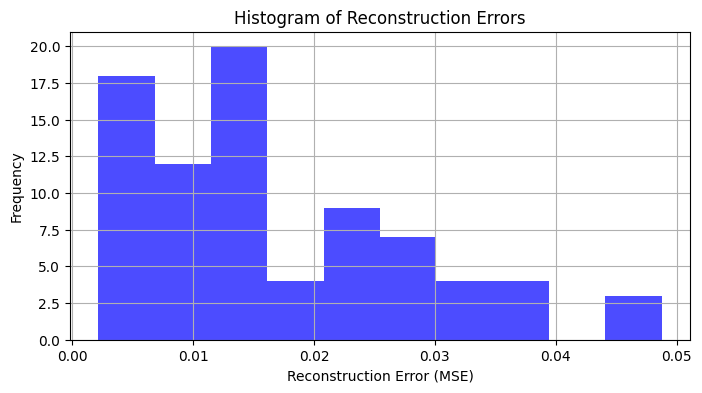

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(loss_bt, alpha=0.7, color='blue')
plt.title("Histogram of Reconstruction Errors")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [27]:
import numpy as np
error_arr = np.array(loss_bt)

percentile = [90, 95, 97.5, 99]

for p in percentile:
    print(f'{p}th percentile : {np.percentile(error_arr, p)}')

90th percentile : 0.031969666481018066
95th percentile : 0.03749861940741539
97.5th percentile : 0.04435153305530548
99th percentile : 0.04592675119638444
